In [1]:
from modeling import PdfBase, Model, Parameter

In [2]:
import numpy as np
from iminuit import Minuit


In [3]:
import matplotlib.pylab as plt
data1 = np.random.normal(loc=20,scale=1, size=1000) # 1st gaussian
data2 = 30*np.random.random(size=1000) # uniform bkg
data3 = np.random.normal(loc=10, scale=10, size=1000) # 2nd gaussian

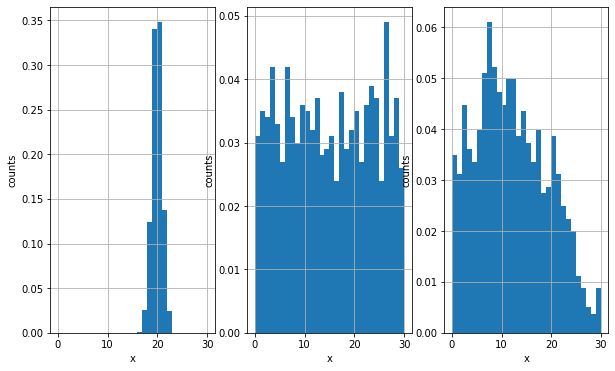

In [4]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
axes[0].grid()
signalPDF, bins, patch = axes[0].hist(data1, bins = 30, range=(0,30), density=True)
axes[0].set_xlabel("x")
axes[0].set_ylabel("counts")

bkgPDF, bins, patch = axes[1].hist(data2, bins = 30, range=(0,30), density=True)
axes[1].grid()
axes[1].set_xlabel("x")
axes[1].set_ylabel("counts")

bkgPDF2, bins, patch = axes[2].hist(data3, bins = 30, range=(0,30), density=True)
axes[2].grid()
axes[2].set_xlabel("x")
axes[2].set_ylabel("counts")

plt.show()
ntotal = 1000
nsig = 0.3 #signal
n1 =  0.4 #First background component.
#third is n2 = 1 - nsig - n1

data = ntotal * (nsig * signalPDF + (1 - nsig) * ( (n1* bkgPDF + (1 - n1)* bkgPDF2)))

[ 23.32508095  22.87596513  28.34938979  26.92811955  23.36204234
  24.29723537  33.20458281  35.14889166  30.36762142  29.955467
  28.62938979  29.88154421  31.28154421  24.05419676  26.42635118
  24.37115816  21.14204234  34.87723537  56.82684932 122.98988792
 130.41419676  62.03596513  27.7407721   20.33469489  18.72861768
  11.42734745  17.38127024  10.77215442  11.92911582  10.94127024]


Text(0, 0.5, 'density')

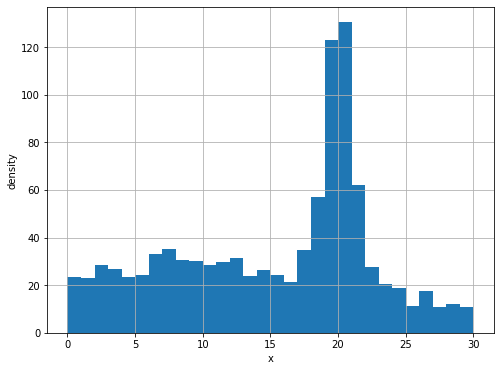

In [5]:
bin_width = np.diff(bins)[0]
bin_centers = bins[:-1] + bin_width/2.

print (data)
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, data,width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [6]:
#from pdf.pdf import PdfBase

SignalPDF = PdfBase(signalPDF, name="SignalPDF")
AtmosPDF = PdfBase(bkgPDF, name="AtmosPDF")
CorsikaPDF = PdfBase(bkgPDF2, name="CorsikaPDF")

sigfrac = Parameter(value=0.3, limits=(0,1), fixed=False, name="n1")
sigatmos_frac = Parameter(value=0.4, limits=(0,1), fixed=False, name="n2")


#data = ntotal * (nsig * signalPDF + (1 - nsig) * ( (n1* bkgPDF + (1 - n1)* bkgPDF2)))

#model = sigfrac * SignalPDF  + (sigatmos_frac * AtmosPDF + CorsikaPDF - sigatmos_frac * CorsikaPDF) - sigfrac * (sigatmos_frac * AtmosPDF) -  sigfrac * CorsikaPDF + sigfrac * (sigatmos_frac * CorsikaPDF)  

model = sigfrac * SignalPDF  + (1 - sigfrac) * ( sigatmos_frac * AtmosPDF + ( 1 - sigatmos_frac)* CorsikaPDF)

#model = ( 1 - sigatmos_frac) * CorsikaPDF

Parameter n2 already exists in the model!
Parameter n1 already exists in the model!


In [8]:
print (model)

 Model: n1*SignalPDF + (1-n1)*(n2*AtmosPDF + (1-n2) * CorsikaPDF)
 Number of pdf: 3
 - SignalPDF
 - AtmosPDF
 - CorsikaPDF
 Number of parameters: 2
 - n1, limits = (0,1),  Is it Fixed? False
 - n2, limits = (0,1),  Is it Fixed? False


In [9]:
print (model.expression)


print (model._pdfs.keys())
print (model._parameters.keys())


print (model[3])

self._parameters['n1'].value*self._pdfs['SignalPDF'][index] + (1 - self._parameters['n1'].value) * (self._parameters['n2'].value*self._pdfs['AtmosPDF'][index] + (1 - self._parameters['n2'].value) * self._pdfs['CorsikaPDF'][index])
odict_keys(['SignalPDF', 'AtmosPDF', 'CorsikaPDF'])
odict_keys(['n1', 'n2'])
0.026580931899641575


Text(0, 0.5, 'density')

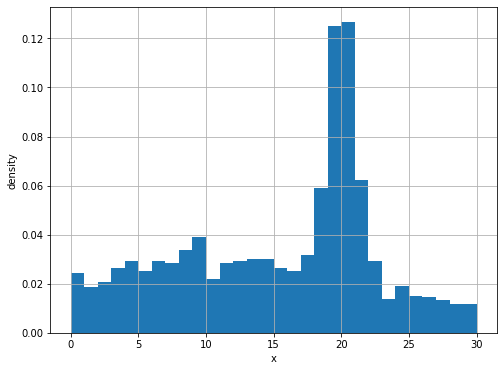

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, model, width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [11]:
dict( model._parameters.items())

{'n1': <modeling.parameter.Parameter at 0x11660a710>,
 'n2': <modeling.parameter.Parameter at 0x11660a5d0>}

In [12]:
def LLH(pars):
    model._parameters["n1"].value = pars[0]
    model._parameters["n2"].value = pars[1]
    
    values = [d * np.log(ntotal*model[i])-ntotal*model[i] for i, d in enumerate(data)]
      
    return -np.sum(values)

In [50]:
LLH([0.2, 0.1])

-2697.924391882181

In [51]:
kwds = dict()
kwds['errordef']=.5
kwds['print_level'] = 2.
#print list(model._parameters.keys())
names = list(model._parameters.keys())
print (names)
limits =([par.limits for par in list(model._parameters.values())])

print (limits)

['n1', 'n2']
[array([0, 1]), array([0, 1])]


In [52]:
m = Minuit.from_array_func(LLH, (0., 0.) , limit=limits, name=names, **kwds)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2727                      │        Ncalls = 54 (54 total)        │
│ EDM = 1.17e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2727                      │        Ncalls = 54 (54 total)        │
│ EDM = 1.17e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1   │   0.300   │   0.018   │            │            │    0    │    1    │       │
│ 1 │ n2   │   0.40    │   0.07    │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [51]:
m

In [38]:
__all__ = [
    "Poisson",
    "Effective",
    "Poissson_with_signal_sustraction",
    "Effective_with_signal_sustraction",
]

class DMfit:
    """"""
    def __init__(self, model, **kwargs):
        self._model = model
        self._meta_data = kwargs.copy()
        
    @property    
    def meta_data(self) -> dict:
        return self._meta_data
    
    def Llh():
        model._parameters["n1"].value = pars[0]
        model._parameters["n2"].value = pars[1]
    
        values = [d * np.log(ntotal*model[i])-ntotal*model[i] for i, d in enumerate(data)]
      
        return -np.sum(values)
    
    